In [599]:
import math
import numpy as np
import matplotlib.pyplot as plt
%mathplotlib	inline

UsageError: Line magic function `%mathplotlib	inline` not found.


In [600]:
def f(x):
    return 3*x**2 - 4*x +5
f(3.0)

20.0

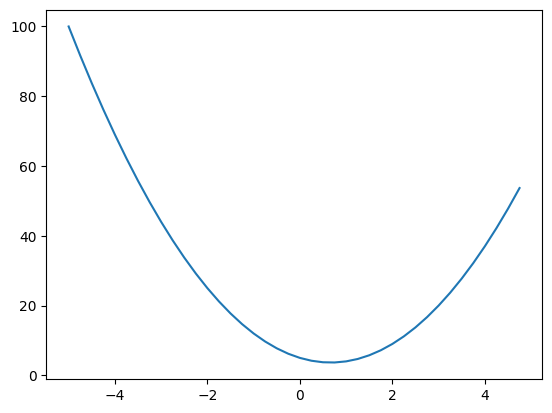

In [601]:
xs = np.arange(-5, 5, 0.25)
ys = f(xs)
plt.plot(xs, ys)

In [602]:
h = 0.00001
x =2/3
(f(x+h)-f(x))/h

3.0000002482211127e-05

In [603]:
h = 0.0001
a = 2.0
b = -3.0
c = 10.0

d1 = a*b + c
c +=h
d2 = a*b + c

print('d1', d1)
print('d2', d2)
print('Slope', (d2-d1)/h)

d1 4.0
d2 4.0001
Slope 0.9999999999976694


In [604]:
class Value:
    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self.grad = 0.0
        self._backward = lambda: None
        self._prev = set(_children)
        self._op = _op
        self.label = label

    def __repr__(self):
        return f"Value(data={self.data})"


    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), '+')
        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
        out._backward = _backward
        return out

    def __sub__(self, other):
        return self + (-other)

    def __radd__(self, other):
        return self + other

    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), '*')
        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward
        return out

    def __rmul__(self, other):
        return self * other

    def __neg__(self):
        return self * -1

    def __pow__(self, other):
        assert isinstance(other,(int, float))
        out = Value( self.data**other, (self,), f'**{other}')
        def _backward():
            # n = other
            self.grad += other * (self.data ** (other-1)) * out.grad
        out._backward = _backward
        return out

    def __truediv__(self, other):
        return self * other ** -1

    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1) / (math.exp(2*x) + 1)
        out = Value(t, (self, ), 'tanh')
        def _backward():
            self.grad += (1 - t**2) * out.grad
        out._backward = _backward
        return out

    def exp(self):
        x=self.data
        out = Value(math.exp(x), (self,), 'exp')
        def _backward():
            self.grad += out.data * out.grad
        out._backward=_backward
        return out

    def backward(self):
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)
        self.grad = 1.0
        for node in reversed(topo):
            node._backward()


a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10.0, label='c')
e = a*b
e.label = 'e'
d = e + c
d.label = 'd'
f = Value(-2.0, label='f')
L = d * f
L.label = 'L'
L
T =L.tanh()
T.label = 'T'

In [605]:
from graphviz import Digraph
def trace(root):
    nodes, edges =set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root):
    dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'})
    nodes, edges= trace(root)
    for n in nodes:
        uid = str(id(n))
        dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f}" % (n.label, n.data, n.grad), shape ='record')
        if n._op:
            dot.node(name = uid + n._op, label = n._op)
            dot.edge(uid + n._op, uid)
    for n1, n2 in edges:
            dot.edge(str(id(n1)), str(id(n2)) + n2._op)

    return dot

In [606]:
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
e = (2*n).exp()
o = (e - 1) / (e + 1)
# o = n.tanh()
o.label = 'o'

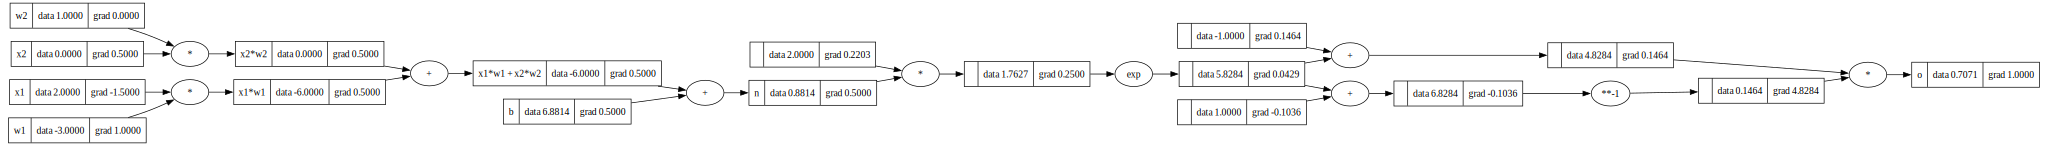

In [607]:
o.backward()
draw_dot(o)

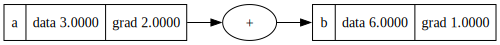

In [608]:
a = Value(3.0, label='a')
b = a + a
b.label = 'b'
b.backward()
draw_dot(b)


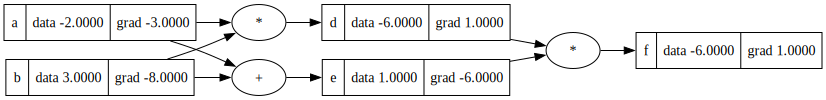

In [609]:
a = Value(-2.0, label='a')
b = Value(3.0, label='b')
d = a * b
d.label = 'd'
e = a + b
e.label = 'e'
f = d * e
f.label = 'f'

f.backward()

draw_dot(f)


In [610]:
import torch
x1 = torch.Tensor([2.0]).double()
x1.requires_grad = True
x2 = torch.Tensor([0.0]).double()
x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double()
w1.requires_grad = True
w2 = torch.Tensor([1.0]).double()
w2.requires_grad = True
b = torch.Tensor([6.8813735870195432]).double()
b.requires_grad = True
n = x1*w1 + x2*w2 + b
o = torch.tanh(n)

print(o.data.item())
o.backward()

print('---')
print('x2', x2.grad.item())
print('w2', w2.grad.item())
print('x1', x1.grad.item())
print('w1', w1.grad.item())


0.7071066904050358
---
x2 0.5000001283844369
w2 0.0
x1 -1.5000003851533106
w1 1.0000002567688737


In [611]:
import random
class Neuron:
    def __init__(self, nin):
        self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
        self.b = Value(random.uniform(-1,1))

    def __call__(self, x):
        act = sum((xi*wi for wi, xi in zip(self.w, x)), self.b)
        out = act.tanh()
        return out
    def parameters(self):
        return self.w + [self.b]


class Layer:
    def __init__(self, nin, nout):
        self.neurons = [Neuron(nin) for _ in range(nout)]

    def __call__(self, x):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs) == 1 else outs

    def parameters(self):
        return [p for neuron in self.neurons for p in neuron.parameters()]

class MLP:
    def __init__(self, nin, nouts):
        sz = [nin] + nouts
        self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]
    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x
    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]


x = [2.0, 3.0, 4.0]
n = MLP(3, [4, 4, 1])
n(x)
(n.parameters())
# draw_dot(n(x))

[Value(data=-0.9414693672371257),
 Value(data=-0.5907058545226802),
 Value(data=0.16849439355674245),
 Value(data=0.028975860850139146),
 Value(data=-0.8253352470594371),
 Value(data=0.4816074808288566),
 Value(data=-0.6828936991168633),
 Value(data=-0.29751436057426894),
 Value(data=-0.15489082768415985),
 Value(data=0.5521223453736543),
 Value(data=-0.43458411414844833),
 Value(data=0.41201775444047906),
 Value(data=-0.6256696823650201),
 Value(data=0.20342927571080827),
 Value(data=0.8143490447137145),
 Value(data=-0.8851140527158663),
 Value(data=0.9323427763909748),
 Value(data=-0.5179727260558125),
 Value(data=0.7719774174372427),
 Value(data=-0.015095515147566907),
 Value(data=-0.5075698372650037),
 Value(data=0.31604986603531193),
 Value(data=-0.18392016898288222),
 Value(data=0.5240957110440367),
 Value(data=0.13361348211554547),
 Value(data=0.8321148276579531),
 Value(data=-0.6218968855893943),
 Value(data=0.03474527195780741),
 Value(data=-0.5766435019942393),
 Value(data=-0

In [612]:
xs = [
    [2.0, 3.0, -1.0],
    [3.0, -1.0, 0.5],
    [0.5, 1.0, 1.0],
    [1.0, 1.0, -1.0],
]
# n = MLP(3, [4, 4, 1])
ys = [1.0, -1.0, -1.0, 1.0]  # desired targets
ypred = [n(x) for x in xs]
ypred

[Value(data=0.875172469272453),
 Value(data=0.8338565531932237),
 Value(data=0.9075225911925545),
 Value(data=0.8813508312504317)]

In [613]:
ypred = [n(x) for x in xs]
loss = sum((yout - ygt) ** 2 for ygt, yout in zip(ys, ypred))
loss
# draw_dot(loss)

Value(data=7.031331831272189)

In [614]:
ypred

[Value(data=0.875172469272453),
 Value(data=0.8338565531932237),
 Value(data=0.9075225911925545),
 Value(data=0.8813508312504317)]

In [615]:
loss.backward()


In [616]:
for p in n.parameters():
    p.data += -0.008 * p.grad


In [617]:

# draw_dot(loss)
n.layers[0].neurons[0].w[0].grad

0.17718327791921568

In [618]:
for p in n.parameters():
    p.data += 0.1 * p.grad

In [619]:
n.layers[0].neurons[0].w[0].data

-0.9251685056685578

In [620]:
loss = sum((yout - ygt) ** 2 for ygt, yout in zip(ys, ypred))
loss

Value(data=7.031331831272189)

In [681]:
for k in range(100000):
    ypred = [n(x) for x in xs]
    loss = sum((yout - ygt) **2 for ygt, yout in zip(ys, ypred))

    for p in n.parameters():
        p.grad = 0.0

    loss.backward()

    for p in n.parameters():
        p.data += -0.01 * p.grad

    print(k, loss.data)

print(ypred)

0 5.869948208195407e-05
1 5.869824537888416e-05
2 5.86970087271087e-05
3 5.869577212662304e-05
4 5.86945355774239e-05
5 5.869329907950877e-05
6 5.869206263287374e-05
7 5.8690826237513664e-05
8 5.8689589893427935e-05
9 5.868835360061254e-05
10 5.8687117359066166e-05
11 5.868588116878302e-05
12 5.868464502976205e-05
13 5.8683408941998646e-05
14 5.868217290549121e-05
15 5.8680936920230974e-05
16 5.8679700986222666e-05
17 5.867846510346184e-05
18 5.8677229271938654e-05
19 5.86759934916596e-05
20 5.8674757762610635e-05
21 5.8673522084797444e-05
22 5.867228645821179e-05
23 5.8671050882854456e-05
24 5.8669815358718954e-05
25 5.866857988580508e-05
26 5.866734446410531e-05
27 5.8666109093620555e-05
28 5.8664873774345e-05
29 5.866363850627761e-05
30 5.866240328941617e-05
31 5.8661168123754874e-05
32 5.8659933009290157e-05
33 5.8658697946020036e-05
34 5.865746293394108e-05
35 5.86562279730532e-05
36 5.8654993063348145e-05
37 5.865375820482633e-05
38 5.865252339748161e-05
39 5.8651288641312056e-05